In [1]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold

from keras.preprocessing.image import ImageDataGenerator
import os

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [4]:
!mkdir main

A subdirectory or file main already exists.


In [5]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
#importing dataset
data = tf.keras.utils.image_dataset_from_directory(
    "main",
    labels='inferred',label_mode='categorical',image_size=(256,256),
    batch_size=1
)

Found 3770 files belonging to 2 classes.


In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal")
])
#random flip augmentation is applied


In [12]:
#creating the augmented dataset
aug_ds = data.map(
  lambda x, y: (data_augmentation(x, training=True), y))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [13]:
class_names = data.class_names
class_names #the image_data_from_directory function choses the folder name as classes

['noStroke_data', 'stroke_data']

In [14]:
dataX = []
dataY = []
for i in data.as_numpy_iterator():
  dataX.append(i[0])
  dataY.append(i[1])


for i in aug_ds.as_numpy_iterator():
  if i[1][0][1] == 1.:
    dataX.append(i[0])
    dataY.append(i[1])
dataX = np.array(dataX)
dataY = np.array(dataY)
dataX = np.reshape(dataX,(dataX.shape[0],256,256,3))
dataY = np.reshape(dataY,(dataY.shape[0],2))
dataX.shape, dataY.shape #87 images in total along with labels


((5029, 256, 256, 3), (5029, 2))

In [15]:
dataY[0]

array([0., 1.], dtype=float32)

In [16]:
def define_model():
  
  model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255), #normalize the data
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(192, activation='relu'),
  tf.keras.layers.Dense(2,activation='sigmoid')
  ])

  opt = tf.keras.optimizers.SGD(learning_rate=0.01)
  model.compile(optimizer=opt, 
                loss=tf.keras.losses.BinaryCrossentropy(), 
                metrics=['accuracy',
                tf.keras.metrics.AUC(name='AUC'),
                tf.keras.metrics.Precision(name='Precision'),
                tf.keras.metrics.Recall(name="Recall")])
  return model


In [17]:
def train_and_evaluate_model(dataX, dataY, n_folds=3):
  scores, histories = list(), list()
  models = []
  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
    model = define_model()
    
    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=1, validation_data=(testX, testY), verbose=1)
    # evaluate model
    _, acc, _ , _, _= model.evaluate(testX, testY, verbose=1)
    print('> %.3f' % (acc * 100.0))
    # stores scores
    scores.append(acc)
    models.append(model)
    histories.append(history)
  model.summary()

  return scores, histories, models

In [18]:
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  colors = ['r','y','blue']
  for i in range(len(histories)):
    # plot loss
    
    pyplot.subplot(2, 1, 1)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(histories[i].history['loss'], color=colors[i], label='train')
    pyplot.plot(histories[i].history['val_loss'], color=colors[i], label='test',ls='dashed')
    # plot accuracy
    pyplot.subplot(2, 1, 2)
    pyplot.title('Classification Accuracy')
    pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
    pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
  
  pyplot.show()


# summarize model performance
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
  # box and whisker plots of results
  pyplot.boxplot(scores)
  pyplot.show()
  

In [19]:
scores, histories, models = train_and_evaluate_model(dataX,dataY)

Epoch 1/10
3352/3352 [==============================] - 2150s 629ms/step - loss: 0.5729 - accuracy: 0.7172 - AUC: 0.7826 - Precision: 0.7191 - Recall: 0.7163 - val_loss: 0.4607 - val_accuracy: 0.7782 - val_AUC: 0.8656 - val_Precision: 0.7696 - val_Recall: 0.7829
Epoch 2/10
3352/3352 [==============================] - 2029s 605ms/step - loss: 0.4326 - accuracy: 0.8079 - AUC: 0.8840 - Precision: 0.8057 - Recall: 0.8079 - val_loss: 0.5777 - val_accuracy: 0.7227 - val_AUC: 0.8295 - val_Precision: 0.7206 - val_Recall: 0.7168
Epoch 3/10
3352/3352 [==============================] - 1962s 585ms/step - loss: 0.3400 - accuracy: 0.8535 - AUC: 0.9322 - Precision: 0.8548 - Recall: 0.8550 - val_loss: 0.2778 - val_accuracy: 0.8861 - val_AUC: 0.9540 - val_Precision: 0.8895 - val_Recall: 0.8831
Epoch 4/10
3352/3352 [==============================] - 3405s 1s/step - loss: 0.2712 - accuracy: 0.9018 - AUC: 0.9598 - Precision: 0.9007 - Recall: 0.9016 - val_loss: 1.1933 - val_accuracy: 0.5802 - val_AUC: 0.6

In [20]:
#metrics for the folds
for i in range(len(histories)):
    p = np.mean(histories[i].history['val_Precision'])
    r = np.mean(histories[i].history['val_Recall'])
    auc = np.mean(histories[i].history['val_AUC'])
    acc = np.mean(histories[i].history['val_accuracy'])
    f1 = (2*(p*r))/(p+r)
    print("Fold "+ str(i+1))
    print(f'Accuracy: {acc*100:.3f}')
    print(f'f1 score: {f1:.3f}')
    print(f'Precision: {p:.3f}')
    print(f'Recall: {r:.3f}')
    print(f'AUC: {auc:.3f}')

Fold 1
Accuracy: 85.337
f1 score: 0.852
Precision: 0.853
Recall: 0.851
AUC: 0.913
Fold 2
Accuracy: 88.998
f1 score: 0.890
Precision: 0.889
Recall: 0.892
AUC: 0.948
Fold 3
Accuracy: 85.477
f1 score: 0.854
Precision: 0.853
Recall: 0.855
AUC: 0.921


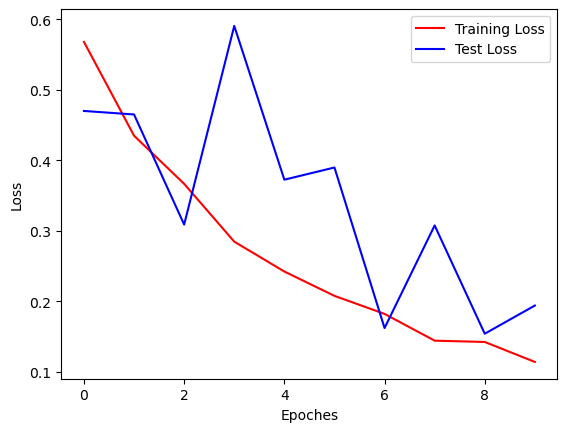

In [21]:
avg_loss = np.add(np.add(histories[0].history['loss'], histories[2].history['loss']), histories[1].history['loss'])/3
avg_val_loss = np.add(np.add(histories[0].history['val_loss'], histories[2].history['val_loss']), histories[1].history['val_loss'])/3
#plot of train vs test loss
plt.plot(avg_loss[:],c='r')
plt.plot(avg_val_loss[:],c='b')
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend(["Training Loss","Test Loss"])
plt.show()

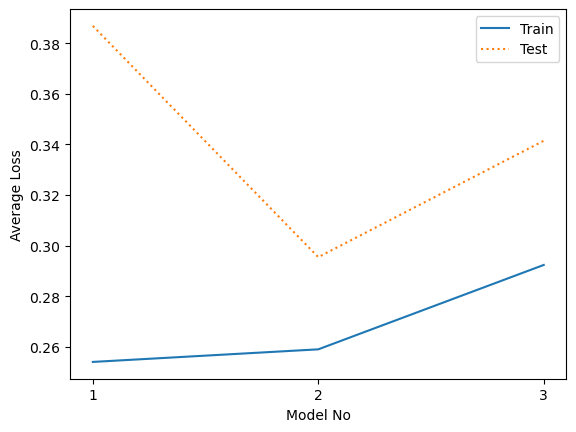

In [22]:
avg_loss = []
avg_val_loss = []
#loss of the different folds
for h in histories:
  avg_loss.append(np.average(h.history['loss']))
  avg_val_loss.append(np.average(h.history['val_loss']))
plt.plot(avg_loss)
plt.plot(avg_val_loss,ls='dotted')
default = range(len(avg_loss))
plt.xlabel('Model No')
plt.xticks(default,[1,2,3])                            
plt.ylabel("Average Loss")
plt.legend(["Train","Test"])
plt.show()

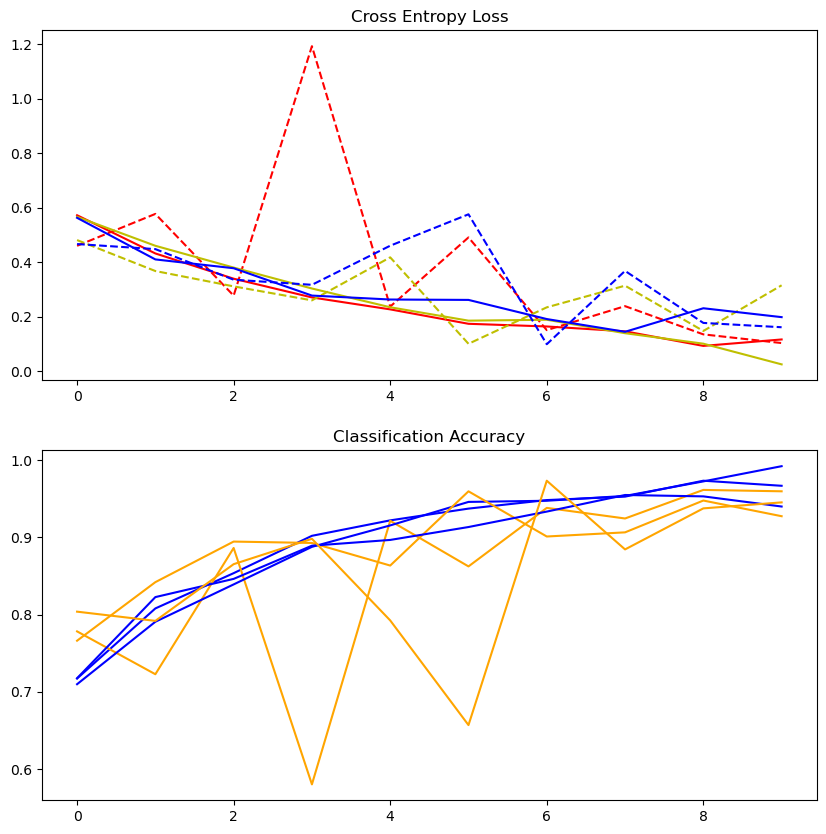

Accuracy: mean=94.392 std=1.319, n=3


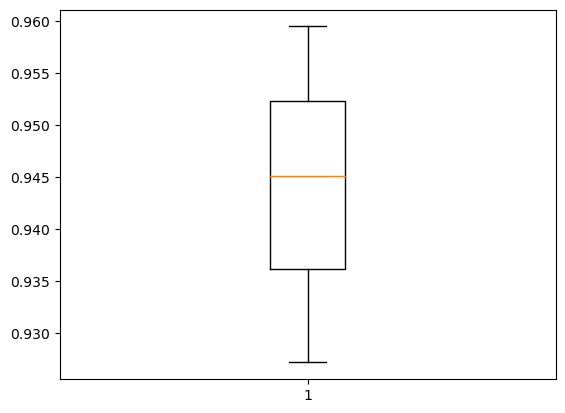

In [23]:
summarize_diagnostics(histories)
summarize_performance(scores)

In [25]:
import pickle

In [26]:
pickle.dump(models, open('model_dump_deep.pkl', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...layers\rescaling
......vars
...metrics\auc
......vars
.........0
.........1
.........2
.........3
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...metrics\precision
......vars
.........0
.........1
...metrics\recall
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-01-20 20:33:35       

In [29]:
import pickle
pickle.dump(models, open('model_dump_deep_deep_learning.pkl', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...layers\rescaling
......vars
...metrics\auc
......vars
.........0
.........1
.........2
.........3
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...metrics\precision
......vars
.........0
.........1
...metrics\recall
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-01-20 20:36:10       

In [42]:
pip install opencv-python

     ---------------------------------------- 38.2/38.2 MB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
